### Importing Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme()

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.set_default_dtype(torch.float32)

%matplotlib inline

### Use GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Bernstein Polynomials

In [3]:
from models.bernstein_torch import bernstein_coeff_order10_new

# Generating P matrix
t_fin = 10.0
num = 100
tot_time = torch.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
P_diag = torch.block_diag(P, P, P, P)

### Load the Training Dataset

In [4]:
# Drone Pose: Indexes [0, 1] - x_init, y_init
drone_pose_idx = [0, 1, 4, 5]
raw_drone_poses_1 = np.load("./new_dataset/1/drone_poses.npy")
raw_drone_poses_2 = np.load("./new_dataset/2/drone_poses.npy")
raw_drone_poses_3 = np.load("./new_dataset/3/drone_poses.npy")
raw_drone_poses_4 = np.load("./new_dataset/4/drone_poses.npy")
raw_drone_poses_5 = np.load("./new_dataset/5/drone_poses.npy")
raw_drone_poses_6 = np.load("./new_dataset/6/drone_poses.npy")
raw_drone_poses_7 = np.load("./new_dataset/7/drone_poses.npy")
raw_drone_poses_8 = np.load("./new_dataset/8/drone_poses.npy")
raw_drone_poses_9 = np.load("./new_dataset/9/drone_poses.npy")
raw_drone_poses_10 = np.load("./new_dataset/10/drone_poses.npy")
raw_drone_poses = np.vstack([raw_drone_poses_1, raw_drone_poses_2, raw_drone_poses_3, raw_drone_poses_4, raw_drone_poses_5,
                             raw_drone_poses_6, raw_drone_poses_7, raw_drone_poses_8, raw_drone_poses_9, raw_drone_poses_10])
drone_poses = np.take(raw_drone_poses, drone_pose_idx, axis=1)

# Useful Indexes [0, 1, 4, 5]
vehicle_pose_idx = [0, 1, 4, 5]
raw_vehicle_poses_1 = np.load("./new_dataset/1/vehicle_poses.npy")
raw_vehicle_poses_2 = np.load("./new_dataset/2/vehicle_poses.npy")
raw_vehicle_poses_3 = np.load("./new_dataset/3/vehicle_poses.npy")
raw_vehicle_poses_4 = np.load("./new_dataset/4/vehicle_poses.npy")
raw_vehicle_poses_5 = np.load("./new_dataset/5/vehicle_poses.npy")
raw_vehicle_poses_6 = np.load("./new_dataset/6/vehicle_poses.npy")
raw_vehicle_poses_7 = np.load("./new_dataset/7/vehicle_poses.npy")
raw_vehicle_poses_8 = np.load("./new_dataset/8/vehicle_poses.npy")
raw_vehicle_poses_9 = np.load("./new_dataset/9/vehicle_poses.npy")
raw_vehicle_poses_10 = np.load("./new_dataset/10/vehicle_poses.npy")
raw_vehicle_poses = np.vstack([raw_vehicle_poses_1, raw_vehicle_poses_2, raw_vehicle_poses_3, raw_vehicle_poses_4, raw_vehicle_poses_5,
                               raw_vehicle_poses_6, raw_vehicle_poses_7, raw_vehicle_poses_8, raw_vehicle_poses_9, raw_vehicle_poses_10])
vehicle_poses = np.take(raw_vehicle_poses, vehicle_pose_idx, axis=1)
vehicle_poses[:, 0:2] = 0

# Trajectory Tracking Velocities
vel_track_1 = np.load("./new_dataset/1/tracking_velocities.npy")
vel_track_2 = np.load("./new_dataset/2/tracking_velocities.npy")
vel_track_3 = np.load("./new_dataset/3/tracking_velocities.npy")
vel_track_4 = np.load("./new_dataset/4/tracking_velocities.npy")
vel_track_5 = np.load("./new_dataset/5/tracking_velocities.npy")
vel_track_6 = np.load("./new_dataset/6/tracking_velocities.npy")
vel_track_7 = np.load("./new_dataset/7/tracking_velocities.npy")
vel_track_8 = np.load("./new_dataset/8/tracking_velocities.npy")
vel_track_9 = np.load("./new_dataset/9/tracking_velocities.npy")
vel_track_10 = np.load("./new_dataset/10/tracking_velocities.npy")
vel_track = np.vstack([vel_track_1, vel_track_2, vel_track_3, vel_track_4, vel_track_5,
                       vel_track_6, vel_track_7, vel_track_8, vel_track_9, vel_track_10])

# Traj Track Final End points
traj_track_1 = np.load("./new_dataset/1/tracking_trajectories.npy")
traj_track_2 = np.load("./new_dataset/2/tracking_trajectories.npy")
traj_track_3 = np.load("./new_dataset/3/tracking_trajectories.npy")
traj_track_4 = np.load("./new_dataset/4/tracking_trajectories.npy")
traj_track_5 = np.load("./new_dataset/5/tracking_trajectories.npy")
traj_track_6 = np.load("./new_dataset/6/tracking_trajectories.npy")
traj_track_7 = np.load("./new_dataset/7/tracking_trajectories.npy")
traj_track_8 = np.load("./new_dataset/8/tracking_trajectories.npy")
traj_track_9 = np.load("./new_dataset/9/tracking_trajectories.npy")
traj_track_10 = np.load("./new_dataset/10/tracking_trajectories.npy")
traj_track = np.vstack([traj_track_1, traj_track_2, traj_track_3, traj_track_4, traj_track_5,
                        traj_track_6, traj_track_7, traj_track_8, traj_track_9, traj_track_10])
end_track = np.hstack([traj_track[:, 0, -1].reshape(-1, 1), traj_track[:, 1, -1].reshape(-1, 1)])

# Rack Trajectories
rack_track_1 = np.load("./new_dataset/1/rack_trajectories.npy")
rack_track_2 = np.load("./new_dataset/2/rack_trajectories.npy")
rack_track_3 = np.load("./new_dataset/3/rack_trajectories.npy")
rack_track_4 = np.load("./new_dataset/4/rack_trajectories.npy")
rack_track_5 = np.load("./new_dataset/5/rack_trajectories.npy")
rack_track_6 = np.load("./new_dataset/6/rack_trajectories.npy")
rack_track_7 = np.load("./new_dataset/7/rack_trajectories.npy")
rack_track_8 = np.load("./new_dataset/8/rack_trajectories.npy")
rack_track_9 = np.load("./new_dataset/9/rack_trajectories.npy")
rack_track_10 = np.load("./new_dataset/10/rack_trajectories.npy")
rack_track = np.vstack([rack_track_1, rack_track_2, rack_track_3, rack_track_4, rack_track_5,
                        rack_track_6, rack_track_7, rack_track_8, rack_track_9, rack_track_10]).reshape(traj_track.shape[0], -1)

# Drone & Vehicle State - Batch x 8
state_data = np.hstack([drone_poses, vehicle_poses, end_track, vel_track, rack_track])[5:] #samples+3]
state_mean, state_std = state_data.mean(), state_data.std()

print(drone_poses.shape, vehicle_poses.shape, traj_track.shape, state_data.shape)

(33382, 4) (33382, 4) (33382, 2, 100) (33377, 212)


### Load the Point Clouds

In [5]:
# Point Cloud
pcd_data_1 = np.load("./new_dataset/1/modified_points.npy")
pcd_data_2 = np.load("./new_dataset/2/modified_points.npy")
pcd_data_3 = np.load("./new_dataset/3/modified_points.npy")
pcd_data_4 = np.load("./new_dataset/4/modified_points.npy")
pcd_data_5 = np.load("./new_dataset/5/modified_points.npy")
pcd_data_6 = np.load("./new_dataset/6/modified_points.npy")
pcd_data_7 = np.load("./new_dataset/7/modified_points.npy")
pcd_data_8 = np.load("./new_dataset/8/modified_points.npy")
pcd_data_9 = np.load("./new_dataset/9/modified_points.npy")
pcd_data_10 = np.load("./new_dataset/10/modified_points.npy")
pcd_data = np.vstack([pcd_data_1, pcd_data_2, pcd_data_3, pcd_data_4, pcd_data_5, 
                      pcd_data_6, pcd_data_7, pcd_data_8, pcd_data_9, pcd_data_10])[5:] #samples+3]
pcd_data = np.transpose(pcd_data, axes=(0, 2, 1))
min_pcd, max_pcd = pcd_data.min(), pcd_data.max()

# Ground Truth Coefficients
drone_coeff_1 = np.load("./new_dataset/1/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_2 = np.load("./new_dataset/2/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_3 = np.load("./new_dataset/3/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_4 = np.load("./new_dataset/4/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_5 = np.load("./new_dataset/5/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_6 = np.load("./new_dataset/6/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_7 = np.load("./new_dataset/7/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_8 = np.load("./new_dataset/8/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_9 = np.load("./new_dataset/9/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff_10 = np.load("./new_dataset/10/drone_best_trajectories.npy").reshape(-1, 22)
drone_coeff = np.vstack([drone_coeff_1, drone_coeff_2, drone_coeff_3, drone_coeff_4, drone_coeff_5,
                         drone_coeff_6, drone_coeff_7, drone_coeff_8, drone_coeff_9, drone_coeff_10])

vehicle_coeff_1 = np.load("./new_dataset/1/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_2 = np.load("./new_dataset/2/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_3 = np.load("./new_dataset/3/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_4 = np.load("./new_dataset/4/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_5 = np.load("./new_dataset/5/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_6 = np.load("./new_dataset/6/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_7 = np.load("./new_dataset/7/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_8 = np.load("./new_dataset/8/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_9 = np.load("./new_dataset/9/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff_10 = np.load("./new_dataset/10/vehicle_best_trajectories.npy").reshape(-1, 22)
vehicle_coeff = np.vstack([vehicle_coeff_1, vehicle_coeff_2, vehicle_coeff_3, vehicle_coeff_4, vehicle_coeff_5,
                           vehicle_coeff_6, vehicle_coeff_7, vehicle_coeff_8, vehicle_coeff_9, vehicle_coeff_10])

expert_coeff = np.hstack([drone_coeff, vehicle_coeff])[5:] #samples+3]

print(state_data.shape, pcd_data.shape, expert_coeff.shape)

(33377, 212) (33377, 2, 200) (33377, 44)


### Dataset Loader

In [6]:
# Custom Dataset Loader 
class TrajDataset(Dataset):
    """Expert Trajectory Dataset."""
    def __init__(self, state_data, pcd_data, expert_coeff):
        
        # State Data
        self.state = state_data
        
        # PCD Data
        self.pcd = pcd_data
        
        # Expert Coeff
        self.gt = expert_coeff
    
    def __len__(self):
        return len(self.state)    
            
    def __getitem__(self, idx):
        
        # Inputs
        state = self.state[idx]
        pcd = self.pcd[idx]
        
        # Outputs
        gt = self.gt[idx]
                 
        return torch.tensor(state).float(), torch.tensor(pcd).float(),torch.tensor(gt).float()

# Batch Size - 3k or 4k
batch_size = 3000

# Using PyTorch Dataloader
train_dataset = TrajDataset(state_data, pcd_data, expert_coeff)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [7]:
print(f"State mean: {state_mean} & std: {state_std}")
print(f"PCD  min: {min_pcd}, max: {max_pcd}")

State mean: -0.4467416132625483 & std: 3.1826055232556145
PCD  min: -62.39320591659159, max: 53.55664677091144


torch.Size([3000, 212]) torch.Size([3000, 2, 200]) torch.Size([3000, 44])


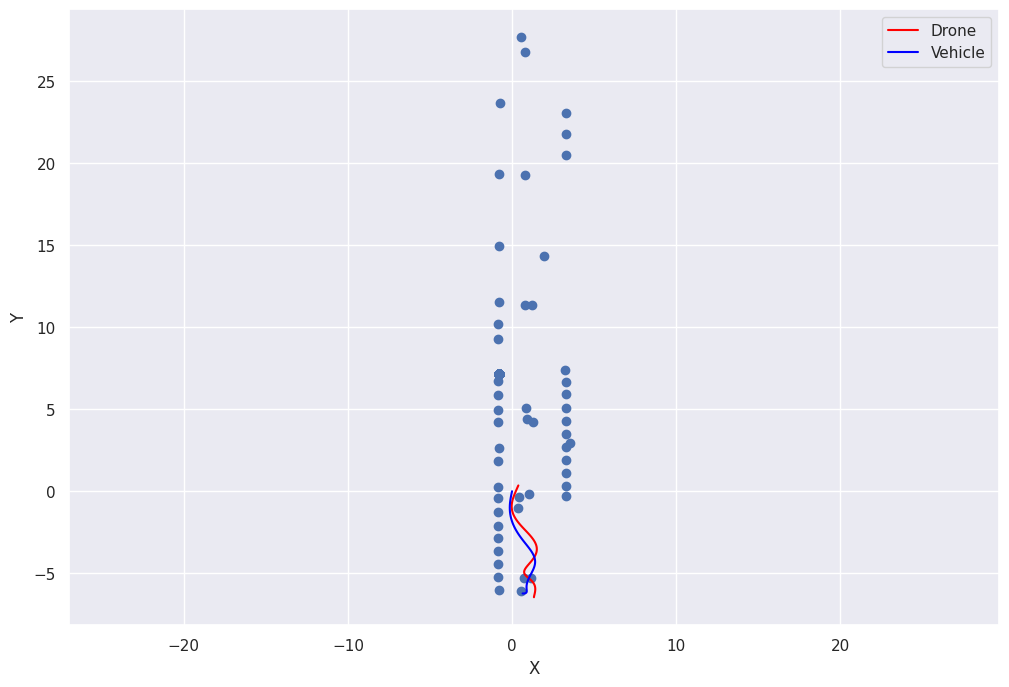

In [8]:
%matplotlib inline

# Sanity Check
for batch_num, (datas) in enumerate(train_loader):
    state, pcd, gt = datas
    
    print(state.shape, pcd.shape, gt.shape)
   
    # Plotting             
    plt.figure(figsize=(12, 8))

    traj_idx = np.random.randint(0, batch_size)
    
    # Point Cloud 
    plt.scatter(pcd[traj_idx, 0, :], pcd[traj_idx, 1, :])

    # Ground Truth trajectories
    traj_gt = (P_diag @ gt.T).T
    traj_drone_gt = traj_gt[:, 0:200]
    traj_vehicle_gt = traj_gt[:, 200:]

    # Plots
    plt.plot(traj_drone_gt[traj_idx, 0:100], traj_drone_gt[traj_idx, 100:], color="red", linewidth=1.5, label="Drone")
    plt.plot(traj_vehicle_gt[traj_idx, 0:100], traj_vehicle_gt[traj_idx, 100:], color="blue", linewidth=1.5, label="Vehicle")
                
    plt.legend()
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    
    break

### CVAE Model

In [9]:
from models.VacnaNet import Encoder, Decoder, Beta_cVAE, PointNet

# Differentiable Layer
num_batch = train_loader.batch_size

P = P.to(device) 
Pdot = Pdot.to(device)
P_diag = P_diag.to(device)

# PointNet
pcd_features = 40
pointnet = PointNet(inp_channel=2, emb_dims=1024, output_channels=pcd_features)

# Beta-cVAE Inputs
enc_inp_dim = 212 + pcd_features 
enc_out_dim = 400
dec_inp_dim = enc_inp_dim
dec_out_dim = 44
hidden_dim = 1024 * 2
z_dim = 6

encoder = Encoder(enc_inp_dim, enc_out_dim, hidden_dim, z_dim)
decoder = Decoder(dec_inp_dim, dec_out_dim, hidden_dim, z_dim)
model = Beta_cVAE(num_batch, P, Pdot, encoder, decoder, pointnet, state_mean, state_std, min_pcd, max_pcd).to(device)

### Training Loop

In [10]:
epochs = 180
step, beta = 0, 3.5 # 3.5
optimizer = optim.AdamW(model.parameters(), lr = 2e-4, weight_decay=6e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 30, gamma = 0.1)

avg_train_loss, avg_rcl_loss, avg_kl_loss = [], [], []
for epoch in range(epochs):
    
    # Train Loop
    losses_train, kl_losses, rcl_losses = [], [], []
    model.train()
    for (state, pcd, gt) in train_loader:
        
        # Input and Output 
        state = state.to(device)
        pcd = pcd.to(device)
        gt = gt.to(device)

        # Traj Ground truth
        traj_gt = (P_diag @ gt.T).T

        # Initial State Drone & Vehicle
        initial_state = state[:, 0:10]
       
        # Forward Pass
        mean, std, y_star = model(state, pcd, traj_gt, initial_state)
        traj_star = (P_diag @ y_star.T).T

        # Loss function
        KL_loss, RCL_loss, loss = model.loss_function(mean, std, traj_star, traj_gt, beta, step)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.detach().cpu().numpy()) 
        rcl_losses.append(RCL_loss.detach().cpu().numpy())
        kl_losses.append(KL_loss.detach().cpu().numpy())

    if epoch % 4 == 0:    
        print(f"Epoch: {epoch + 1}, Train Loss: {np.average(losses_train):.3f}, RCL: {np.average(rcl_losses):.3f}, KL: {np.average(kl_losses):.3f}")

    step += 0.25 #0.15
    scheduler.step()
    avg_train_loss.append(np.average(losses_train)), avg_rcl_loss.append(np.average(rcl_losses)), \
    avg_kl_loss.append(np.average(kl_losses))

Epoch: 1, Train Loss: 5.148, RCL: 5.148, KL: 5.821
Epoch: 5, Train Loss: 2.572, RCL: 2.556, KL: 4.397
Epoch: 9, Train Loss: 1.286, RCL: 1.263, KL: 3.228
Epoch: 13, Train Loss: 0.657, RCL: 0.629, KL: 2.649
Epoch: 17, Train Loss: 0.382, RCL: 0.349, KL: 2.377
Epoch: 21, Train Loss: 0.261, RCL: 0.223, KL: 2.193
Epoch: 25, Train Loss: 0.214, RCL: 0.171, KL: 2.049
Epoch: 29, Train Loss: 0.195, RCL: 0.149, KL: 1.869
Epoch: 33, Train Loss: 0.195, RCL: 0.147, KL: 1.706
Epoch: 37, Train Loss: 0.197, RCL: 0.147, KL: 1.588
Epoch: 41, Train Loss: 0.199, RCL: 0.148, KL: 1.443
Epoch: 45, Train Loss: 0.202, RCL: 0.151, KL: 1.341
Epoch: 49, Train Loss: 0.207, RCL: 0.155, KL: 1.232
Epoch: 53, Train Loss: 0.208, RCL: 0.157, KL: 1.125
Epoch: 57, Train Loss: 0.210, RCL: 0.159, KL: 1.039
Epoch: 61, Train Loss: 0.212, RCL: 0.161, KL: 0.963
Epoch: 65, Train Loss: 0.214, RCL: 0.163, KL: 0.919
Epoch: 69, Train Loss: 0.217, RCL: 0.165, KL: 0.872
Epoch: 73, Train Loss: 0.220, RCL: 0.168, KL: 0.822
Epoch: 77, Trai

### Saving the Weights

In [ ]:
torch.save(model.state_dict(), './weights/hmnet_no_acc_zdim_6.pth')